In [831]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import numpy as np

import operator
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

import warnings
warnings.filterwarnings("ignore")

##Data preparation

In [47]:
data = []
with open('data.json') as f:
    for line in f:
        data.append(json.loads(line))

In [49]:
data = map(lambda x: json_normalize(x), data)

In [58]:
data_df = pd.concat(data)

In [94]:
# set id as the index
data_df = data_df.set_index('id')

## Data cleaning

We add three new columns, one for the total number of versions of a bill iterated through (num_versions), one for the text of the last document (last_doc), and one denoting whether the bill passed or not (passed).

First we add num_versions and last_doc.

In [383]:
# we know that all bills have a first version
np.unique(data_df['documents.0'].isnull())

array([False], dtype=bool)

In [259]:
def get_num_versions(row):
    """ gets the number of total versions of the document """
    row_is_null = row.isnull()
    if row_is_null['documents.1']:
        return 1
    elif row_is_null['documents.2']:
        return 2
    elif row_is_null['documents.3']:
        return 3
    else:
        return 4

In [260]:
def get_last_version(row):
    """ gets the last version of the document """
    row_is_null = row.isnull()
    if row_is_null['documents.1']:
        return row['documents.0']
    elif row_is_null['documents.2']:
        return row['documents.1']
    elif row_is_null['documents.3']:
        return row['documents.2']
    else:
        return row['documents.3']

In [261]:
data_df['num_versions'] = data_df.apply(get_num_versions, axis=1)
data_df['last_doc'] = data_df.apply(get_last_version, axis=1)

Next, we add pass. Zero means the bill failed to pass, while one means success. We see in the data that there are some discrepancies, like both actions.failed and actions.resolution_passed for index 10 are null. We choose to use actions.failed as our benchmark because at first glace it seems more accurate.

In [424]:
def get_passed(row):
    if row['actions.failed']=='null':
        return 1
    else:
        return 0

In [427]:
data_df['passed'] = data_df.apply(get_passed, axis=1)

## Natural Language Processing

In [118]:
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')

In [119]:
from sklearn.feature_extraction import text 
stopwords=text.ENGLISH_STOP_WORDS

#### Parsing Language

In [123]:
import re
# remove ellipses, dashes, and parenthetical phrases
regex1 = re.compile(r"\.{2,}")
regex2 = re.compile(r"\-{2,}")
regex3 = re.compile("^TEMPLATES = \(.+\)")

In [589]:
def get_parts(thetext):
    """ get the nouns and verbs for every sentence in text """
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    nouns=[]
    verbs=[]
    for i,sentence in enumerate(parse(thetext, tokenize=True, lemmata=True).split()):
        nouns.append([])
        verbs.append([])
        for token in sentence:
            if len(token[4]) > 0:
                # get all verbs
                if token[1] in ['VBP', 'VB', 'VBD', 'VBG', 'VBN', 'VPB', 'VBZ']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation \
                    or len(token[4])==1:
                        continue
                    verbs[i].append(token[4])
                # get all nouns    
                elif token[1] in ['NN', 'NNS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation \
                    or len(token[4])==1:
                        continue
                    nouns[i].append(token[4])
    out=zip(nouns, verbs)
    nouns2=[]
    verbs2=[]
    for n,v in out:
        if len(n)!=0:
            nouns2.append(n)
            verbs2.append(v)
    return nouns2, verbs2

In [303]:
nv_doc = data_df['last_doc'].apply(get_parts)

In [306]:
# unpack the pandas Series of tuples to a DataFrame
nv_df = pd.DataFrame(nv_doc.tolist(), columns=['nouns','verbs'], index=nv_doc.index)

In [299]:
def list_to_string(row):
    """ turns a list of lists to a string """
    noun_list = [item for sublist in row for item in sublist]
    return ' '.join(noun_list)

In [307]:
# flatten the list and turn it to a string for use in LDA 
nouns = nv_df['nouns'].apply(list_to_string)

## Latent Dirichlet Analysis

In [292]:
import gensim
from sklearn.feature_extraction.text import CountVectorizer

In [448]:
def LDA(nouns, passes=1):
    """ performs LDA on a corpus of nouns """
    vectorizer = CountVectorizer(min_df=1, stop_words='english')
    X=vectorizer.fit_transform(nouns)
    corpus=vectorizer.get_feature_names()
    id2words = dict((v, k) for k, v in vectorizer.vocabulary_.iteritems())
    corpus_gensim = gensim.matutils.Sparse2Corpus(X, documents_columns=False)
    lda = gensim.models.ldamodel.LdaModel(corpus_gensim, id2word=id2words, num_topics=5, 
                                      update_every=1, chunksize=1000, passes=passes)
    return lda

In [312]:
lda = LDA(nouns)
lda.print_topics()

[u'0.033*section + 0.015*vehicle + 0.015*tax + 0.014*year + 0.014*person + 0.013*subdivision + 0.013*taxpayer + 0.012*credit + 0.012*state + 0.011*property',
 u'0.045*court + 0.038*person + 0.036*section + 0.022*defendant + 0.021*order + 0.017*subdivision + 0.015*state + 0.012*victim + 0.011*officer + 0.011*county',
 u'0.027*section + 0.021*fund + 0.019*year + 0.017*program + 0.016*state + 0.016*item + 0.014*subdivision + 0.013*service + 0.012*county + 0.012*payment',
 u'0.036*section + 0.027*subdivision + 0.017*person + 0.015*information + 0.011*agency + 0.010*notice + 0.009*state + 0.008*corporation + 0.008*business + 0.008*action',
 u'0.028*section + 0.026*child + 0.026*school + 0.017*service + 0.015*department + 0.015*care + 0.014*person + 0.013*subdivision + 0.011*parent + 0.011*county']

We can pick out some patterns in $5$ the groups. The clusters seem to be as follows:

1. Acts regarding driving and taxes
2. Acts regarding the courts and crimes.
3. Acts regarding program funding.
4. Acts regarding business and regulations.
5. Acts regarding child care and education.

However, there is quite a bit of noise, most likely due to the fact that we used the entire text. Let's try again, this time with part of the document, since they all seem to start with a general overview of what the act is about. 

After diving into the data, we notice that the majority of the relevant information comes in the beginning sentence. Thus, we only look at the first list element in our nv_doc to look at the nouns in our first sentence.

In [365]:
nv_small_df = nv_df['nouns'].apply(get_beginning)

In [368]:
def get_beginning(row):
    """ get the nouns corresponding to the first sentence """
    if len(row) > 0:
        return row[0]
    else:
        return row

In [376]:
nouns_small = nv_small_df.apply(lambda x: ' '.join(x))

In [382]:
lda_small = LDA(nouns_small)
lda_small.print_topics()

[u'0.068*person + 0.064*section + 0.033*follows + 0.017*school + 0.011*child + 0.011*care + 0.010*subdivision + 0.010*pupil + 0.010*health + 0.010*year',
 u'0.043*person + 0.038*section + 0.024*vehicle + 0.020*follows + 0.013*election + 0.012*subdivision + 0.011*license + 0.010*county + 0.009*officer + 0.009*law',
 u'0.123*state + 0.036*loan + 0.031*bond + 0.029*fund + 0.029*director + 0.022*purpose + 0.021*improvement + 0.019*development + 0.018*dollar + 0.017*grant',
 u'0.064*section + 0.035*person + 0.025*follows + 0.020*property + 0.020*service + 0.014*tax + 0.014*subdivision + 0.013*year + 0.010*revenue + 0.010*health',
 u'0.043*section + 0.025*state + 0.023*follows + 0.021*person + 0.017*subdivision + 0.017*agency + 0.016*program + 0.015*district + 0.013*county + 0.012*year']

Interestingly, the above clusters seem to make a bit more sense. We stick with those.

#### Comparing the topics of successful and failed bills

Now we run LDA on the groups of passed and failed bills to see if the topics tend to be different between the two groups.

In [436]:
passed_bills = data_df[data_df['passed']==1].index.values
failed_bills = data_df[data_df['passed']==0].index.values

In [437]:
passed_bills

array([    6,    10,    13, ..., 14763, 14765, 14768])

In [445]:
nouns_passed = nouns[nouns.index.isin(passed_bills)]
nouns_failed = nouns[nouns.index.isin(failed_bills)]

In [450]:
# number of passes increased here to improve accuracy
lda_pass = LDA(nouns_passed, 3)
lda_pass.print_topics()

[u'0.035*section + 0.017*member + 0.016*person + 0.016*employee + 0.016*subdivision + 0.013*state + 0.012*board + 0.011*corporation + 0.011*business + 0.010*purpose',
 u'0.025*section + 0.016*subdivision + 0.014*agency + 0.013*vehicle + 0.013*property + 0.009*state + 0.009*project + 0.009*person + 0.008*county + 0.008*city',
 u'0.041*child + 0.029*section + 0.025*court + 0.018*subdivision + 0.017*parent + 0.017*service + 0.016*person + 0.013*order + 0.012*care + 0.011*agency',
 u'0.039*section + 0.034*school + 0.026*subdivision + 0.024*person + 0.020*district + 0.018*county + 0.018*year + 0.014*state + 0.013*court + 0.011*paragraph',
 u'0.026*section + 0.021*fund + 0.021*program + 0.018*service + 0.017*item + 0.017*department + 0.014*state + 0.014*year + 0.013*plan + 0.013*health']

In [452]:
# number of passes increased here to improve accuracy
lda_failed = LDA(nouns_failed, 3)
lda_failed.print_topics()

[u'0.024*section + 0.018*water + 0.017*license + 0.014*person + 0.014*licensee + 0.013*department + 0.013*fee + 0.012*state + 0.009*sale + 0.009*chapter',
 u'0.036*section + 0.019*year + 0.018*subdivision + 0.016*tax + 0.015*state + 0.012*business + 0.012*agency + 0.011*county + 0.011*property + 0.011*member',
 u'0.076*fund + 0.065*item + 0.035*payment + 0.029*support + 0.023*project + 0.020*expenditure + 0.019*loan + 0.019*provision + 0.017*cost + 0.016*appropriation',
 u'0.033*section + 0.024*school + 0.020*service + 0.019*program + 0.018*subdivision + 0.015*department + 0.014*year + 0.014*district + 0.013*county + 0.013*health',
 u'0.037*person + 0.036*section + 0.023*court + 0.021*subdivision + 0.011*state + 0.010*law + 0.010*violation + 0.009*order + 0.008*information + 0.008*commission']

Some interesting patterns that come out at first glance:

Topics/keywords that are part of the the passed bills but not the failed bills:
    - employees
    - vehicles (i.e. driving laws)
    - children
    - school
    
Common themes for successful bills are people and their safety,well-being, conditions, etc. 

Topics/keywords that are part of the failed bills but not the passed bills:
    - water
    - tax
    - payment
    - loan
    - information
    
A common theme for failed bills is money.
        
Topics that are prominent in both. In other words, these are a mixed bag in terms of their success in passing in MD and CA:
    - health
    - business
    - fund 
    - court

Common themes for both successful and failed bills are health, business, and law, as well as funding. 

## Model Building

We want to build a predictive model around whether or not a bill will pass. 

#### Split into training and test

In [263]:
from sklearn.cross_validation import train_test_split
train, test = train_test_split(xrange(data_df.shape[0]), train_size=0.8)
mask=np.ones(data_df.shape[0])
mask[train]=1
mask[test]=0
mask = (mask==1)

In [472]:
train_set = data_df[mask]
test_set = data_df[~mask]
train_words = nv_df[mask]
test_words = nv_df[~mask]

####Words-only features
First, we fit a random forest model on the words alone. Even though we ran LDA on our document texts, we revert to the titles to cretae out bag of words for the model features. Quick analysis showed that the number of features goes from almost $25,000$ to about $2,500$ when we choose to use the titles instead. This will help our random forest classifier run more quickly.

In [594]:
def get_nouns(thetext):
    """ get the nouns and verbs from the title """
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    nouns=[]
    for i,sentence in enumerate(parse(thetext, tokenize=True, lemmata=True).split()):
        for token in sentence:
            if len(token[4]) > 0:
                # get all nouns    
                if token[1] in ['NN', 'NNS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation \
                    or len(token[4])==1:
                        continue
                    nouns.append(token[4])
    return nouns

In [615]:
# get the words on the full data set and training set
nouns_title = data_df['title'].apply(get_nouns).apply(lambda x: ' '.join(x))
train_nouns_title = nouns_title[mask].apply(lambda x: ' '.join(x))

# initialize and fit the vectorizer, the bag of words tool
vectorizer1 = CountVectorizer(min_df=1, stop_words='english')
vectorizer1.fit(train_nouns_title)
title_word_features = vectorizer1.transform(nouns_title)
title_word_features = title_word_features.toarray()

# get the number of features
num_feat = title_word_features.shape[1]

# get the list of words (vocab_list)
vocab_dict = vectorizer1.vocabulary_
sorted_vocab = sorted(vocab_dict.items(), key=operator.itemgetter(1))
vocab_list = [el[0] for el in sorted_vocab]

# create a dataframe of just the words and the response variable
title_words_df = pd.DataFrame(title_word_features, columns=vocab_list, index=data_df.index)
title_words_df['passed'] = data_df['passed']

We write some functions to optimize for our hyperparameters and to print the training and test set accuracy.

In [540]:
from sklearn.grid_search import GridSearchCV
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    """ optimize hyperparameters via cross validation """
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

In [738]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val,\
                mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    """ measure both the training and test set accuracy of the classifier """
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print "Out-of-bag error: %0.2f" % (1 - clf.oob_score_)
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [739]:
%time
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(RandomForestClassifier(oob_score=True), None, title_words_df, \
                                                      vocab_list, 'passed',1, mask=mask, n_jobs = 4, score_func='f1')

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 15 µs
using mask
############# based on standard predict ################
Accuracy on training data: 0.86
Accuracy on test data:     0.65
Out-of-bag error: 0.34
########################################################


There seems to be a big difference between the training set and test set accuracies. This seems to suggest overfitting to the training set, but we see this is not the case because the training set out of bag score is approximately the same as the test set accuracy, at around $.65$ or $.66$.

Ideally, I would be able to optimize my hyperparameters. With time, I would run the following code and various iterations of it:

In [ ]:
parameters = {"n_estimators": range(10,50), "min_samples_split": range(1,5), 'max_features': range(num_feat/2, num_feat)}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(RandomForestClassifier(oob_score=True), parameters, title_words_df, vocab_list, 'passed',1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

We take a look at the most important features, or in this case, the words that have the most predictive power.

In [753]:
def plot_imp_feats(clfForest, feat_cols):
    """ plot the 20 most important features as determined by the 
        Random Forest Algorithm """
    feat_importance = clfForest.feature_importances_
    sorted_feat_importance = sorted(feat_importance, reverse=True)
    #get the top twenty most important features
    top_feats = sorted_feat_importance[:20]
    indices = [feat_importance.tolist().index(feature) for feature in top_feats]
    top_feat_names = [feat_cols[index] for index in indices]
    num_feats = range(1, len(top_feats)+1)
    plt.barh(num_feats, top_feats)
    plt.yticks(num_feats, top_feat_names)
    plt.title("Top 20 Most Important Features")
    return top_feat_names

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 30 µs


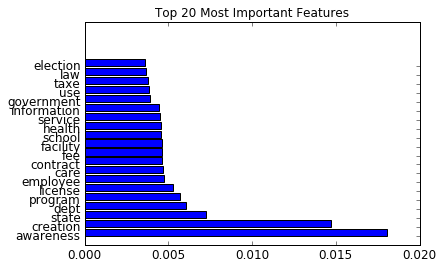

In [754]:
%time
top20_words = plot_imp_feats(clfForest, vocab_list)

Here we see the top 20 most important words to predict the success of a bill. We see that many of those correspond to the words when we compare the distributions of the successful and failed bill topics, such as employee, school, and information. Others were not seen before, such as awareness, state, debt, and creation. Some were present in both groups, such as program, service, and health. We explore these features further.

Let's start with awareness.

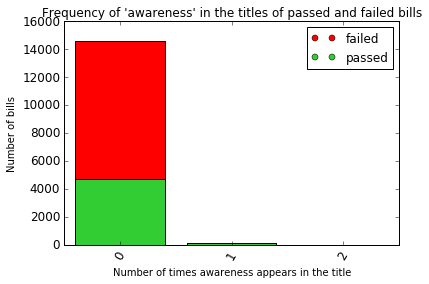

In [793]:
passed = title_words_df[title_words_df['passed']==1]['awareness'].tolist()
failed = title_words_df[title_words_df['passed']==0]['awareness'].tolist()
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)

vals = pd.Series(title_words_df['awareness'].values.ravel()).unique()
freq_passed = []
freq_failed = []

num_val = range(1,len(vals)+1)
for value in vals:
    freq_passed.append(passed.count(value))
    freq_failed.append(failed.count(value))

plt.bar(num_val,freq_passed,align='center',color='limegreen')
plt.bar(num_val,freq_failed,align='center',color='r', bottom=freq_passed)

plt.xticks(num_val, vals, rotation = 60)
use_colors = {"passed": "limegreen", "failed": "red"}
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in use_colors.values()]

plt.legend(markers,use_colors.keys())
plt.ylabel("Number of bills")
plt.xlabel("Number of times awareness appears in the title")
plt.title("Frequency of 'awareness' in the titles of passed and failed bills")


Interestingly, we see that bills with awareness in the title were more likely to pass than bills without. Only successful bills had awareness twice in the title.

In [804]:
print freq_passed
print freq_failed

[4679, 124, 6]
[9937, 23, 0]


We do the same thing for all the words in the top twenty most important features. Unfortunately the bar plots are not extremely informative since the number of bills without each of the words greatly overshadows those with, as seen below:

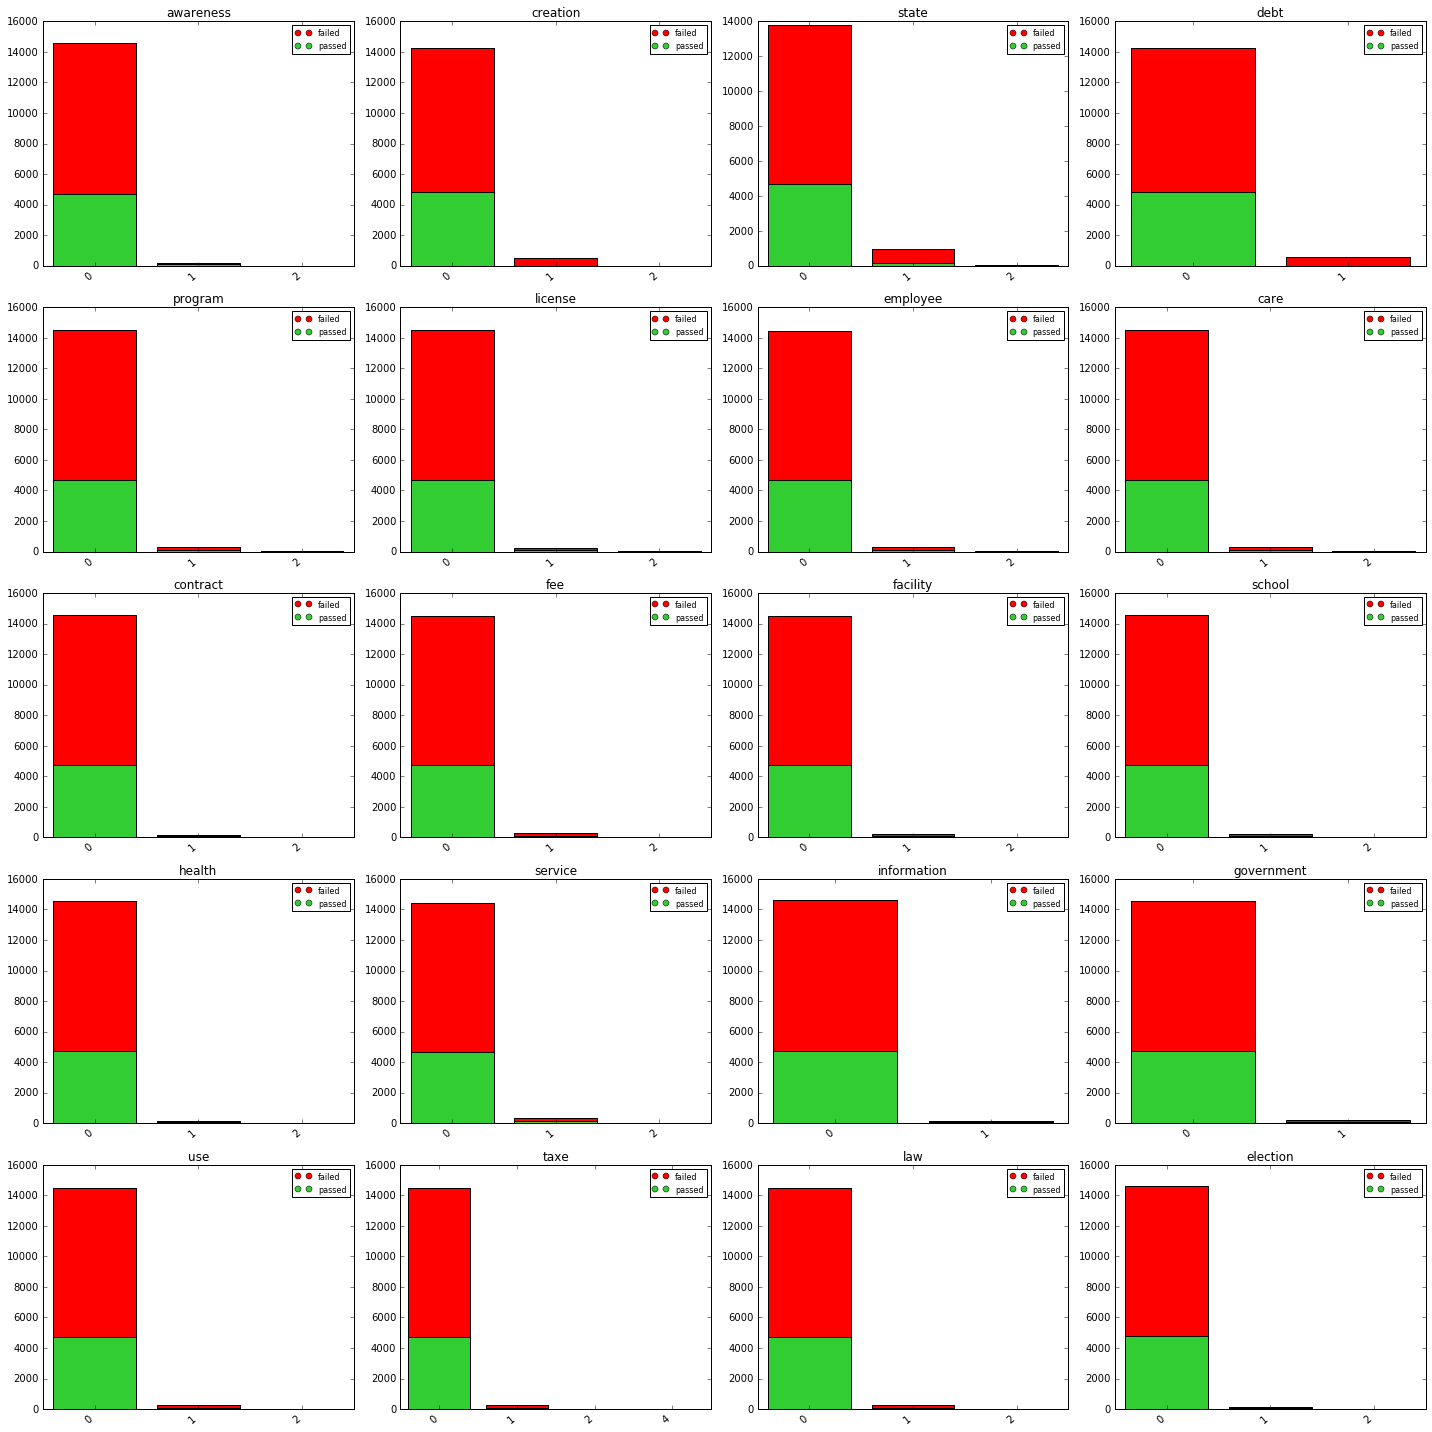

In [813]:
fig1, axes1 = plt.subplots(5,4,tight_layout=True,figsize=(20,20))

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
for j, variable in enumerate(top20_words):
    ax1 = axes1[j/4,j%4]
    passed = title_words_df[title_words_df['passed']==1][variable].tolist()
    failed = title_words_df[title_words_df['passed']==0][variable].tolist()
    vals = pd.Series(title_words_df[variable].values.ravel()).unique()
    freq_passed = []
    freq_failed = []

    num_val = range(1,len(vals)+1)
    for value in vals:
        freq_passed.append(passed.count(value))
        freq_failed.append(failed.count(value))

    ax1.bar(num_val,freq_passed,align='center',color='limegreen')
    ax1.bar(num_val,freq_failed,align='center',color='r', bottom=freq_passed)
    ax1.legend(markers,use_colors.keys(),loc='best',fontsize='8')
    ax1.set_xticks(num_val)
    ax1.set_xticklabels(vals,ha='right',rotation=40)
    ax1.set_title(variable)

plt.show()

We instead look at the percentage of passed bills:

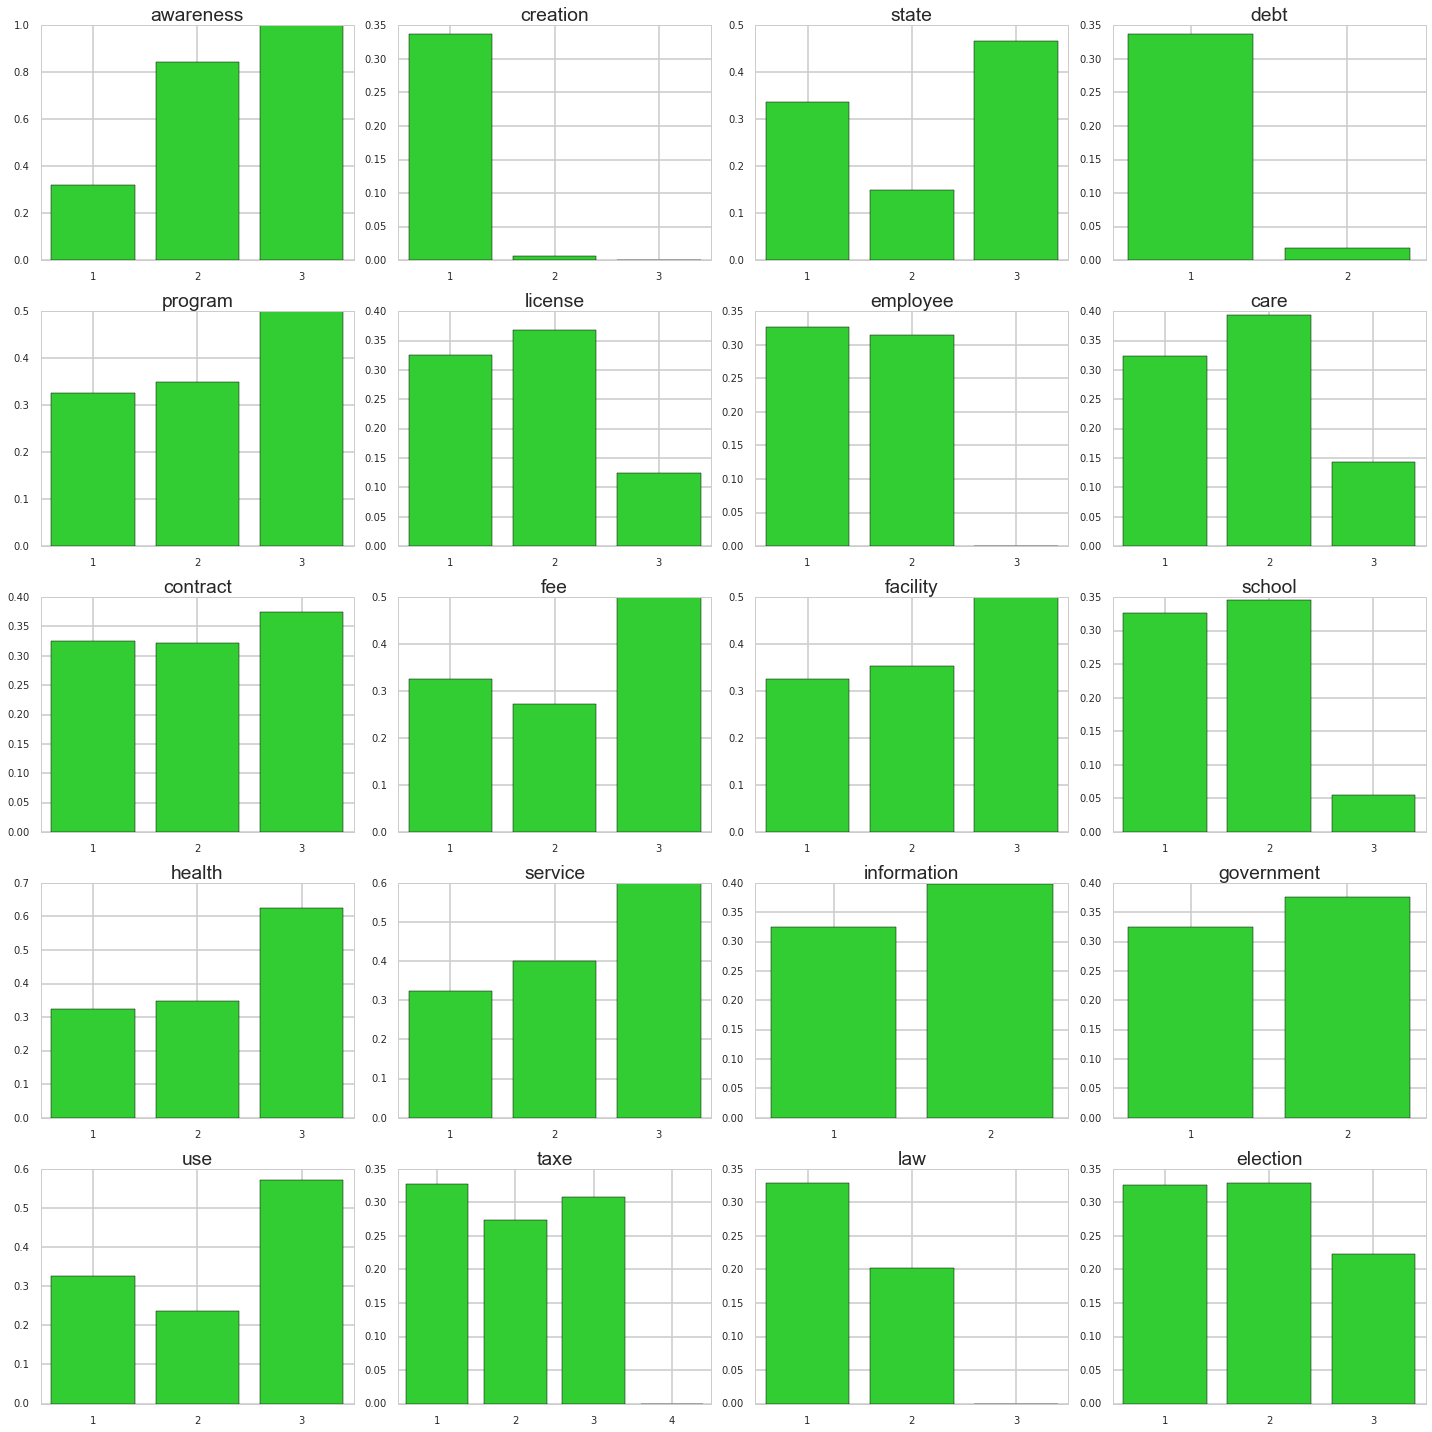

In [853]:
fig1, axes1 = plt.subplots(5,4,tight_layout=True,figsize=(20,20))
for j, variable in enumerate(top20_words):
    ax1 = axes1[j/4,j%4]
    passed = title_words_df[title_words_df['passed']==1][variable].tolist()
    failed = title_words_df[title_words_df['passed']==0][variable].tolist()
    vals = pd.Series(title_words_df[variable].values.ravel()).unique()
    prop_passed = []

    num_val = range(1,len(vals)+1)
    for value in vals:
        prop_passed.append(float(passed.count(value))/float(failed.count(value)+passed.count(value)))
        
    ax1.bar(num_val,prop_passed,align='center',color='limegreen')
    ax1.set_xticks(num_val)
    ax1.set_title(variable)

Some immediate insights:

1. Bills with 'awareness','program', 'health', 'service', and 'facility' in their titles have increased likelihood of success in comparison to bills without those words, and an even higher chance when those words appear twice.
2. Bills with 'creation', 'debt', and 'law' in their titles have a decreased likelihood of success, even more so when those words appear twice.
3. Some words tend to be negatively correlated with success when appearing once, but positively correlated when appearing twice. These include 'use', 'state', and 'fee'.
4. Others tend to be positively correlated when appearing once, then negatively correlated when appearing twice. These include 'school', 'care', and 'license'.

####Adding more features
We now add other features to our classifier.

In [645]:
def get_primary_sponsor(row):
    """ gets the primary sponsor party of the bill.
        If more than one party involved, return most represented. """
    parties = []
    for sponsor in row:
        if sponsor['type'] == 'primary':
            parties.append(sponsor['party'])
    if parties:
        return max(set(parties), key=parties.count)
    else:
        return parties

In [648]:
other_df = data_df[['bill_type', 'chamber', 'state', 'session','num_versions','passed']]
other_df['num_sponsors'] = data_df['sponsors'].apply(lambda x: len(x))
other_df['primary_party_sponsor'] = data_df['sponsors'].apply(get_primary_sponsor) 


We see that we need to clean the data values in the column 'primary_party_sponsor'.

In [682]:
np.unique(other_df['primary_party_sponsor'])

array([None, [], u'Democratic', u'Democratic Party', u'Republican',
       u'Republican Party'], dtype=object)

In [685]:
def format_party(row):
    """ Cleans the column so only Democratic, Republican, and None are values """
    if row=='Democratic Party':
        return 'Democratic'
    elif row=='Republican Party':
        return 'Republican'
    elif not row:
        return None
    else:
        return row

In [687]:
other_df['primary_party_sponsor'] = other_df['primary_party_sponsor'].apply(format_party)
CATEGORICAL = ['bill_type', 'chamber', 'state', 'session', 'primary_party_sponsor']
other_df = pd.get_dummies(other_df, columns=CATEGORICAL)
# create a new df of the word and non-word features
new_df = pd.concat([title_words_df, other_df], axis=1)

In [688]:
# list of features
feat_list = vocab_list + list(other_df.columns)
feat_list.remove('passed')

In [740]:
%time
clfForest1, Xtrain1, ytrain1, Xtest1, ytest1 = do_classify(RandomForestClassifier(oob_score=True), None, new_df, feat_list, 'passed',1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 35 µs
using mask
############# based on standard predict ################
Accuracy on training data: 0.96
Accuracy on test data:     0.77
Out-of-bag error: 0.25
########################################################


Once again, we see that the model is not overfitting to the training set as our training set out-of-bag score (i.e. 1-out-of-bag error) is similar to our test set accuracy.

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 26 µs


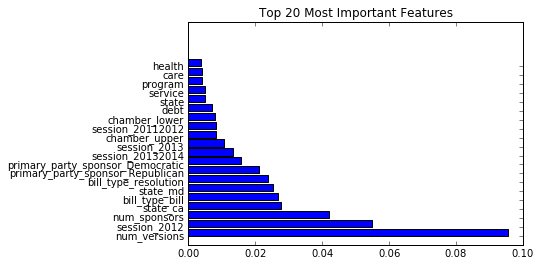

In [806]:
%time
top20 = plot_imp_feats(clfForest1, feat_list)

Here, we see that the most important features tend to be the quantitative ones, followed by the state then the party. We do a similar analysis to before to see how these features affect the success of a bill.

In [830]:
QUANTITATIVE = ['num_versions','num_sponsors']
INDICATOR = top20
INDICATOR.remove('num_versions')
INDICATOR.remove('num_sponsors')

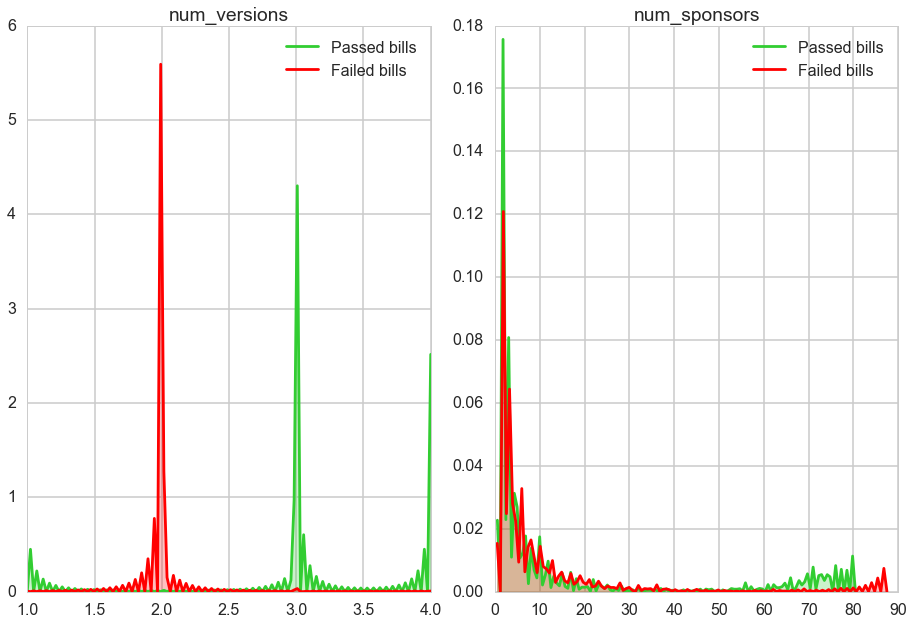

In [843]:
fig, axes = plt.subplots(ncols=2)

for i, feature in enumerate(QUANTITATIVE):
    ax = axes[i]
    sns.kdeplot(new_df[new_df['passed']==1][feature], ax=ax, shade=True,color='limegreen', label="Passed bills")
    sns.kdeplot(new_df[new_df['passed']==0][feature], ax=ax, shade=True,color='red', label="Failed bills")
    ax.set_title(feature)
fig.tight_layout()

Interestingly, most failed bills had exactly 2 versions, meaning failed bills tended to revised just once but no more. While some bills passed on their first version, most passed on their 3rd or 4th, meaning that bills that went over more than one revision tended to have the highest likelihood of success. In regards to sponsors, bills that had around $70$ to $80$ sponsors tended to have a higher chance of success, but bills with more than that many sponsors tended to fail.

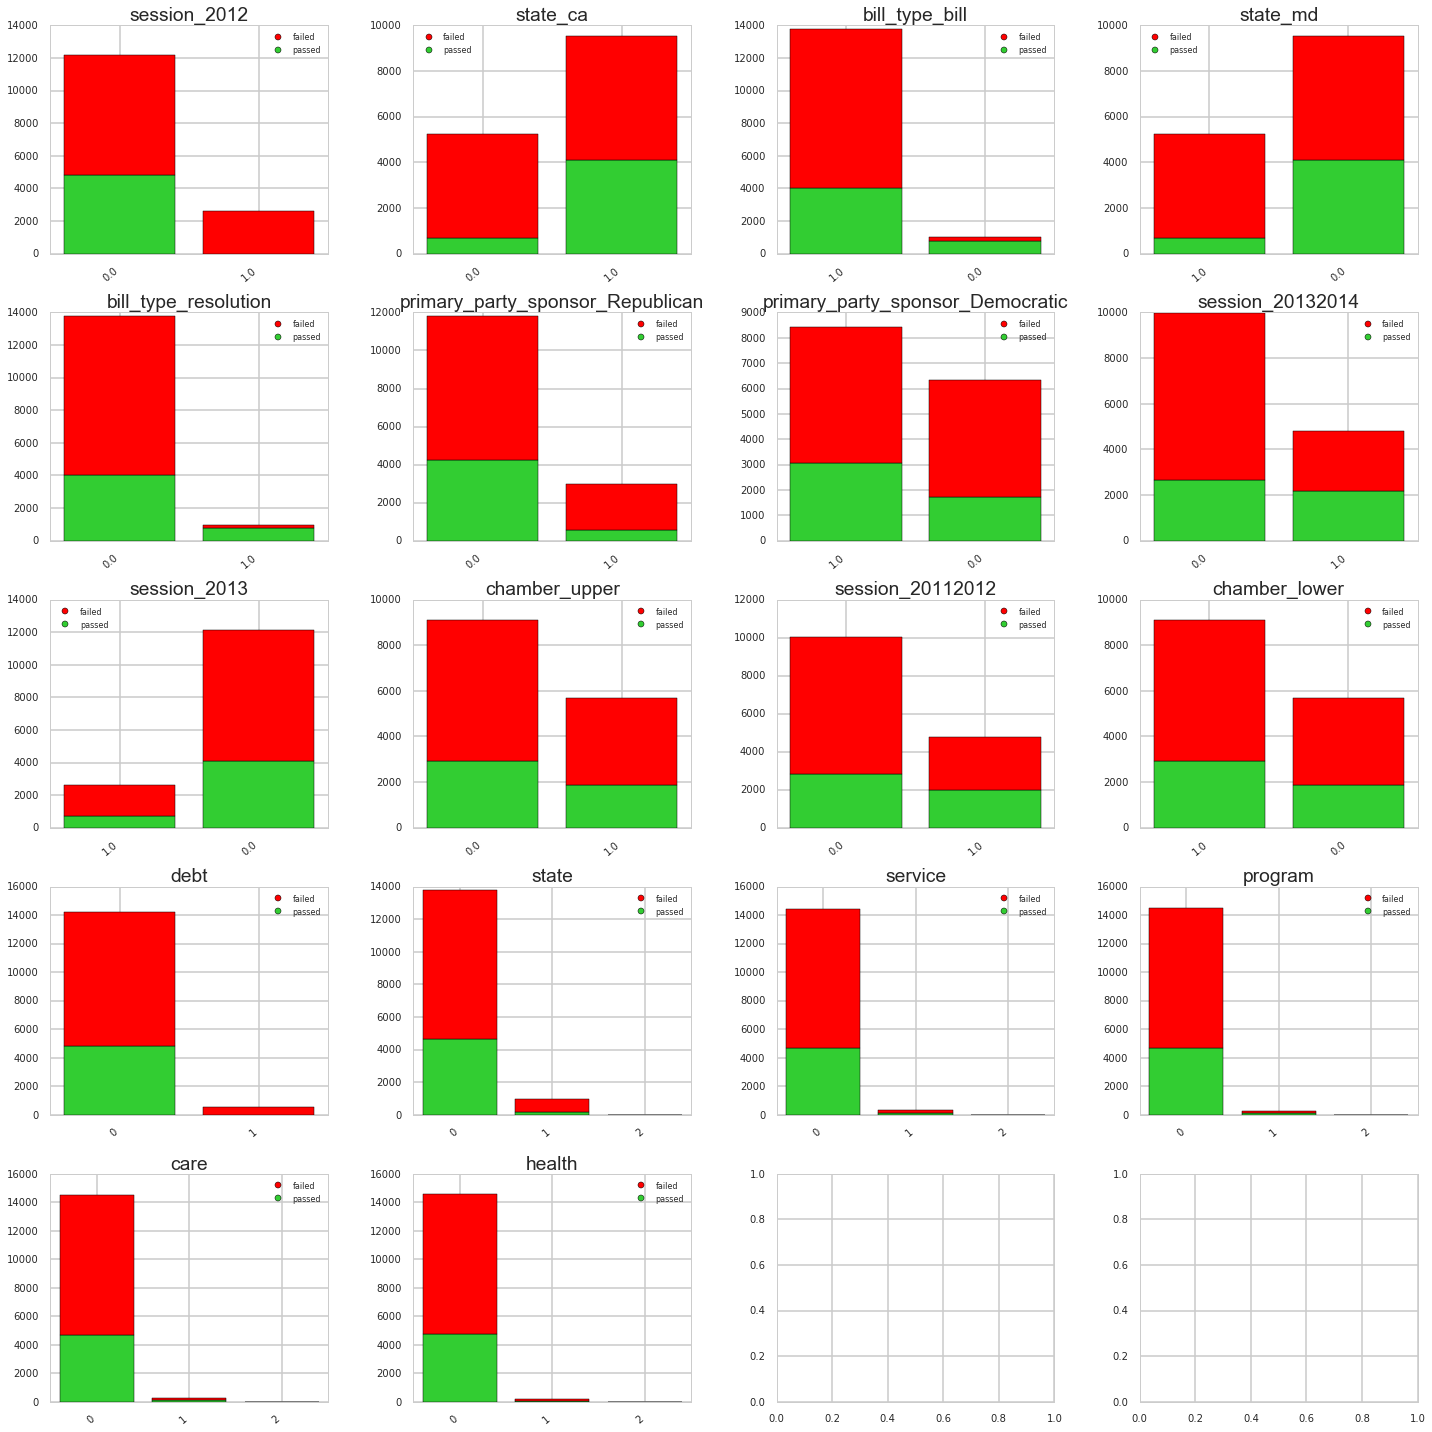

In [847]:
fig, axes = plt.subplots(5,4,tight_layout=True,figsize=(20,20))

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
for j, variable in enumerate(INDICATOR):
    ax = axes[j/4,j%4]
    passed = new_df[new_df['passed']==1][variable].tolist()
    failed = new_df[new_df['passed']==0][variable].tolist()
    vals = pd.Series(new_df[variable].values.ravel()).unique()
    freq_passed = []
    freq_failed = []

    num_val = range(1,len(vals)+1)
    
    for value in vals:
        freq_passed.append(passed.count(value))
        freq_failed.append(failed.count(value))

    ax.bar(num_val,freq_passed,align='center',color='limegreen')
    ax.bar(num_val,freq_failed,align='center',color='r', bottom=freq_passed)
    ax.legend(markers,use_colors.keys(),loc='best',fontsize='8')
    ax.set_xticks(num_val)
    ax.set_xticklabels(vals,ha='right',rotation=40)
    ax.set_title(variable)

plt.show()

Here, we see that:

1. Resolutions are much more likely to pass than bills.
2. Almost no legislation passed in session 2012. Legislation was much more likely to pass during the 2011-2012 and 2013-2014 session.


## Diving further

With more time, I would like to explore both the EDA and the model building further. In particular, I would also like to:

1. Build more nuance into my model labels. Maybe instead of just pass or not, I could have four labels for passed in both houses, passed in the House, passed in the Senate, and failed in both.
2. Improve my model accuracy. This would include optimizing for my hyperparamters and experimenting with more classifiers. This could also end in an ensemble classifier of different types of classifiers. I would also add more features, some ideas of which I describe below.
2. Look for more temporal patterns, such as whether a greater proporation of bills tend to be passed right before election period, etc. This could come in the form of some time series analysis, plots, and including features like the number of days the bill was in debate (i.e. from the day of introduction to the day of voting).
3. Incorporating insights from my latent dirichlet model into my predictive random forest model. For example, using the documents' topic distributions as features in the model building would be similar but possibly more interesting and interpretable than just using bag of words.
4. Spend more time parsing words. These would include words that are commonplace in legislation but not necessarily the English language.
5. Performing some analysis on the verbs used, since legislation has a lot of do with garnering action, and it could be informative to see which verbs tended to be in the most successfull bills and possibly even incorporate that in my models. I had originally intended to do such, as I parsed both the nouns and verbs from the documents, but ultimately just stuck with nouns for simplicity.
6. Incorporate more people features into the model. For example, this would include having dummy indicators for all the individuals and whether or not they sponsored or cosponsored the bill, etc. I would also like to perform more EDA on the representatives, such as seeing what sorts of bills different representatives tend to supprt/oppose and measure these differences between individuals to see who are most similar, etc.